# 4. Statistical Analysis and Interpretation

This final notebook is for analyzing the results generated in Notebook 03. We will load the `all_plant_model_results.csv` file and perform the following analyses:

1.  **Overall Model Performance:** Determine which growth model was the best fit most often across all plants.
2.  **Genotype Analysis:** Compare the fitted model parameters (now treated as plant traits) across different genotypes.
3.  **Heritability Calculation:** Calculate the broad-sense heritability ($H^2$) for the key model parameters to see if these derived traits have a genetic basis.

## 4.1 Imports and Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the parent directory to the system path to allow imports from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom functions
from src.data_processing import load_data, preprocess_data
from src.analysis import calculate_heritability

# Load the original raw data to create merged_df
FEATURES_PATH = '../data/5.25.2024_CBI.0010_York_Poplar_RGB.side_features.csv'
BARCODE_PATH = '../data/barcodes--5.25.2024_CBI.0010_York_Poplar.csv'
data_df, barcode_df = load_data(FEATURES_PATH, BARCODE_PATH)
merged_df = preprocess_data(data_df, barcode_df)
print(f"Original merged_df loaded with shape: {merged_df.shape}")

# Set plot styles
%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

Original merged_df loaded with shape: (3407, 63)


## 4.2 Load Results

Load the CSV file containing the results from the per-plant model fitting.

In [8]:
# Define file path and load data
RESULTS_PATH = '../results/data/all_plant_model_results.csv'
results_df = pd.read_csv(RESULTS_PATH)

print("Results data shape:", results_df.shape)
results_df.head()

Results data shape: (446, 41)


,Plant Info,Plant Genotype,m0_optimal_linear,k_optimal_linear,Cost_Linear,AIC_Linear,R2_Linear,R2_adj_Linear,W0_optimal_ricker,kg_optimal_ricker,...,A_optimal_gvb,Cost_Gen_VB,AIC_Gen_VB,R2_Gen_VB,R2_adj_Gen_VB,Linear_AIC_Weight,Ricker_AIC_Weight,Logistic_AIC_Weight,Exponential_AIC_Weight,Gen_VB_AIC_Weight
0,22_BESC-1126_2,BESC-1126,0.000000,0.032305,0.004043,-34.085887,9.699482e-01,0.957927,0.210486,0.070950,...,0.938109,0.000304,-39.776709,0.997737,0.994720,0.016849,1.689401e-07,0.693148,0.000058,0.289945
1,23_BESC-1207_2,BESC-1207,0.284176,0.000000,0.103168,-5.099760,-2.220446e-16,-0.500000,0.284176,0.000000,...,0.800000,0.103792,14.142418,-0.006044,-2.018131,0.486686,1.329807e-02,0.013298,0.486686,0.000032
2,24_BESC-317_2,BESC-317,0.000000,0.029134,0.005413,-31.751534,9.542177e-01,0.935905,0.194432,0.065742,...,0.919042,0.002505,-22.915341,0.978812,0.950562,0.679131,1.884795e-05,0.198567,0.114095,0.008188
3,25_GW-9919_3,GW-9919,0.000000,0.034356,0.003572,-35.077977,9.726055e-01,0.961648,0.225741,0.071977,...,0.987899,0.001479,-27.128717,0.988652,0.973522,0.117337,2.008635e-06,0.880229,0.000227,0.002204
4,26_BESC-1068_5,BESC-1068,0.000000,0.025446,0.016021,-23.070858,8.671459e-01,0.814004,0.171145,0.060512,...,0.941606,0.000146,-45.631095,0.998786,0.997166,0.000007,3.699288e-09,0.407160,0.001804,0.591029


## 4.3 Analyze Overall Model Performance

Let's find out which model was the "best" fit most frequently. We can do this by finding the model with the highest **AIC Weight** for each plant.

C:\Users\katie\AppData\Local\Temp\ipykernel_8752\3829316248.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=results_df, x='Best_Model', order=results_df['Best_Model'].value_counts().index, palette='viridis')


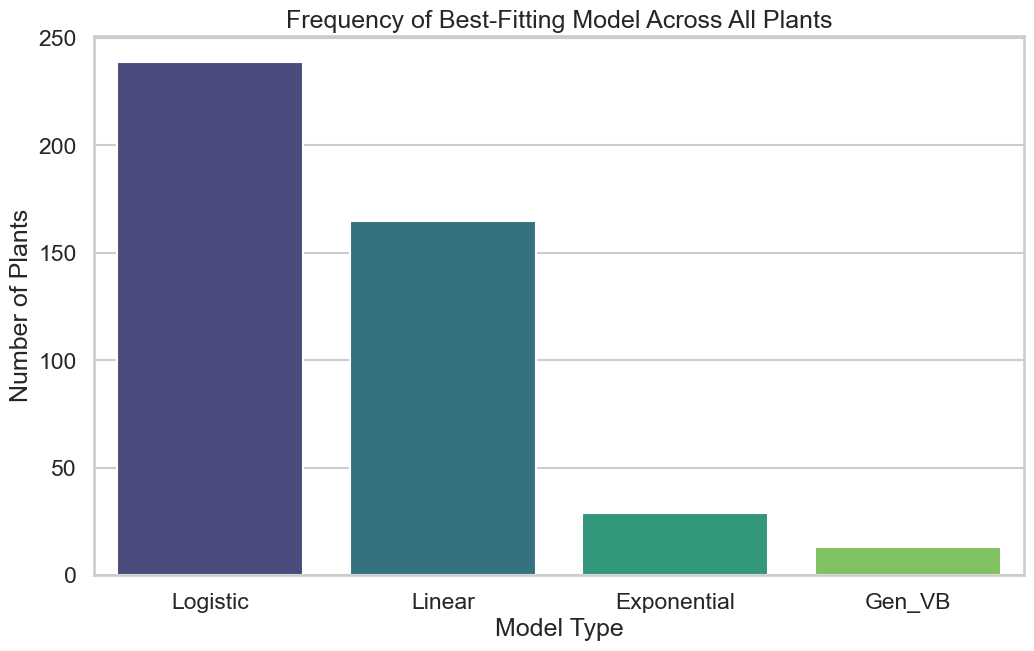

In [9]:
# Identify the AIC Weight columns
weight_cols = [col for col in results_df.columns if 'AIC_Weight' in col]

# For each row (plant), find the column name with the maximum AIC weight
results_df['Best_Model'] = results_df[weight_cols].idxmax(axis=1)

# Clean up the name for better plotting
results_df['Best_Model'] = results_df['Best_Model'].str.replace('_AIC_Weight', '')

# Plot the counts of the best model
plt.figure(figsize=(12, 7))
sns.countplot(data=results_df, x='Best_Model', order=results_df['Best_Model'].value_counts().index, palette='viridis')
plt.title('Frequency of Best-Fitting Model Across All Plants')
plt.xlabel('Model Type')
plt.ylabel('Number of Plants')
plt.show()

## 4.4 Analyze Trait Differences Between Genotypes

The parameters from the fitted models (like the logistic growth rate `r` or carrying capacity `K`) can now be treated as new, quantitative traits for each plant. Let's visualize the distribution of a key trait, the **Logistic Carrying Capacity (`K_optimal_log`)**, for each genotype.

C:\Users\katie\AppData\Local\Temp\ipykernel_8752\3955664918.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Plant Genotype', y='K_optimal_log', palette='coolwarm')


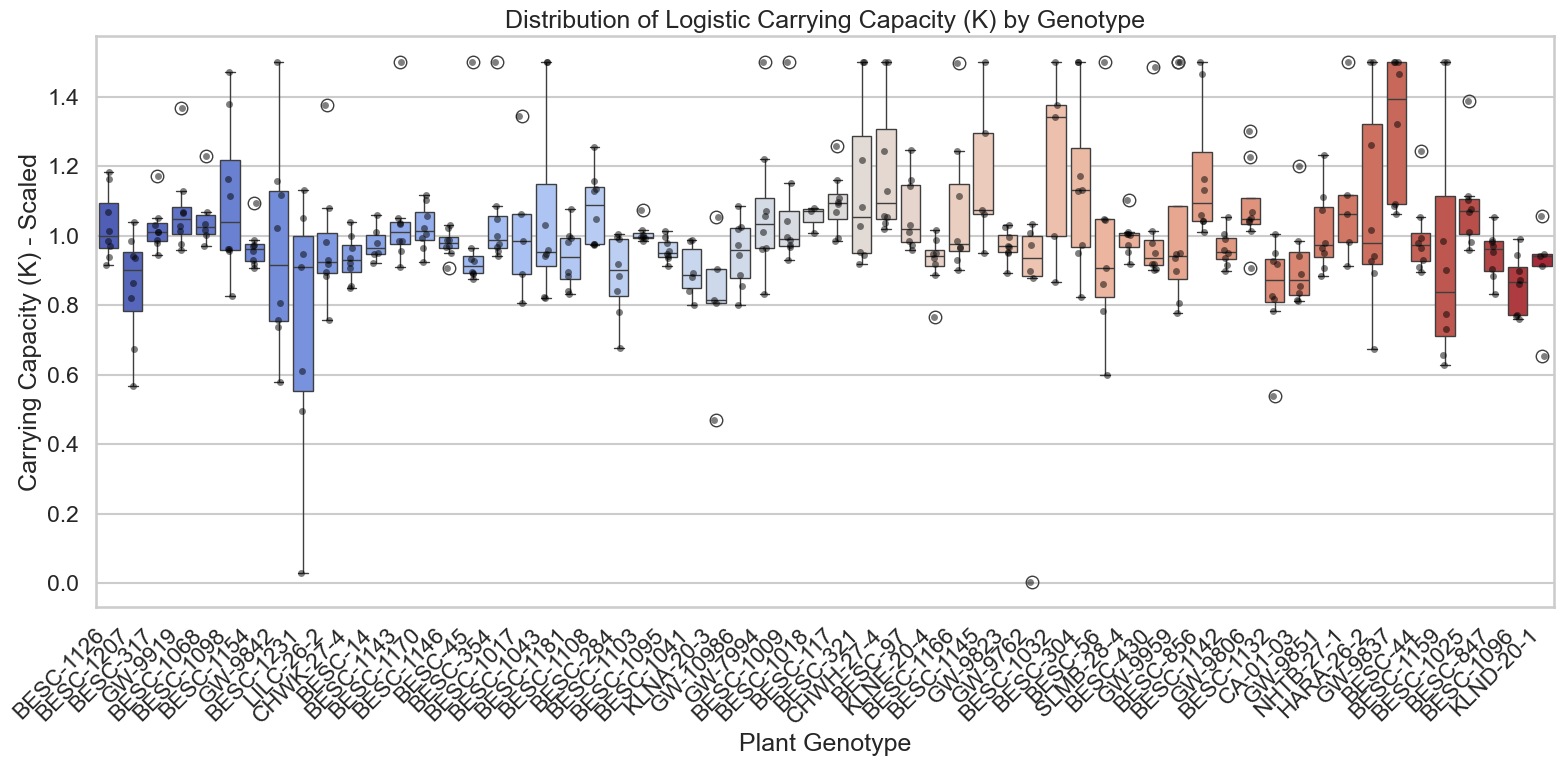

In [10]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=results_df, x='Plant Genotype', y='K_optimal_log', palette='coolwarm')
sns.stripplot(data=results_df, x='Plant Genotype', y='K_optimal_log', color='black', alpha=0.5)
plt.title('Distribution of Logistic Carrying Capacity (K) by Genotype')
plt.ylabel('Carrying Capacity (K) - Scaled')
plt.xlabel('Plant Genotype')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.5 Heritability Analysis ($H^2$)

This is the final and most important analysis. We'll calculate the **broad-sense heritability ($H^2$)** for our new traits (the model parameters). This tells us what proportion of the variation in a trait is due to genetic differences between the genotypes.

We will use our `calculate_heritability` function, which performs an ANOVA under the hood to estimate the variance components.

In [11]:
# Define the trait columns and their human-readable labels
# This is based on your original notebook's final analysis
trait_cols = [
    'k_optimal_linear', 'K_optimal_log', 'r_optimal_log', 
    'm_optimal_ricker', 'kg_optimal_ricker', 'A_optimal_gvb', 
    'f_optimal_gvb', 'k_optimal_gvb'
]

trait_labels = {
    'k_optimal_linear': 'Linear Growth Rate (k)',
    'K_optimal_log': 'Logistic Carrying Capacity (K)',
    'r_optimal_log': 'Logistic Growth Rate (r)',
    'm_optimal_ricker': 'Ricker Peak Biomass (m)',
    'kg_optimal_ricker': 'Ricker Growth Rate (kg)',
    'A_optimal_gvb': 'GVB Asymptote (A)',
    'f_optimal_gvb': 'GVB Shape (f)',
    'k_optimal_gvb': 'GVB Growth Rate (k)'
}

# Run the heritability analysis
heritability_summary_df = calculate_heritability(results_df, trait_cols, trait_labels)

# Display the final table
print("Broad-Sense Heritability (H²) Summary:")
print(heritability_summary_df.to_string(index=False))

Broad-Sense Heritability (H²) Summary:
                         Trait  MS Genotype  MS Error  n_r  Var(G)  Var(E)  Var(P)    H²
        Linear Growth Rate (k)       0.0001    0.0000 7.16  0.0000  0.0000  0.0000 0.211
Logistic Carrying Capacity (K)       0.0804    0.0326 7.16  0.0067  0.0326  0.0393 0.170
      Logistic Growth Rate (r)       0.1179    0.0345 7.16  0.0117  0.0345  0.0461 0.253
       Ricker Peak Biomass (m)       0.0068    0.0053 7.16  0.0002  0.0053  0.0055 0.037
       Ricker Growth Rate (kg)       0.0049    0.0034 7.16  0.0002  0.0034  0.0036 0.061
             GVB Asymptote (A)       0.0042    0.0035 7.16  0.0001  0.0035  0.0036 0.027
                 GVB Shape (f)       0.0220    0.0165 7.16  0.0008  0.0165  0.0172 0.045
           GVB Growth Rate (k)       0.1156    0.0434 7.16  0.0101  0.0434  0.0534 0.189


### 4.6 Conclusion

From the heritability table, we can draw conclusions about which aspects of plant growth are most strongly influenced by genetics in this experiment. Traits with a higher $H^2$ value (e.g., > 0.5) are considered to have a strong genetic component, making them good candidates for further study or breeding programs.

This concludes the analysis workflow.

--- Visualizing Final Area ---


C:\Users\katie\AppData\Local\Temp\ipykernel_8752\3611573818.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_with_final_area, x='Plant Genotype', y='Final_Area', palette='coolwarm')


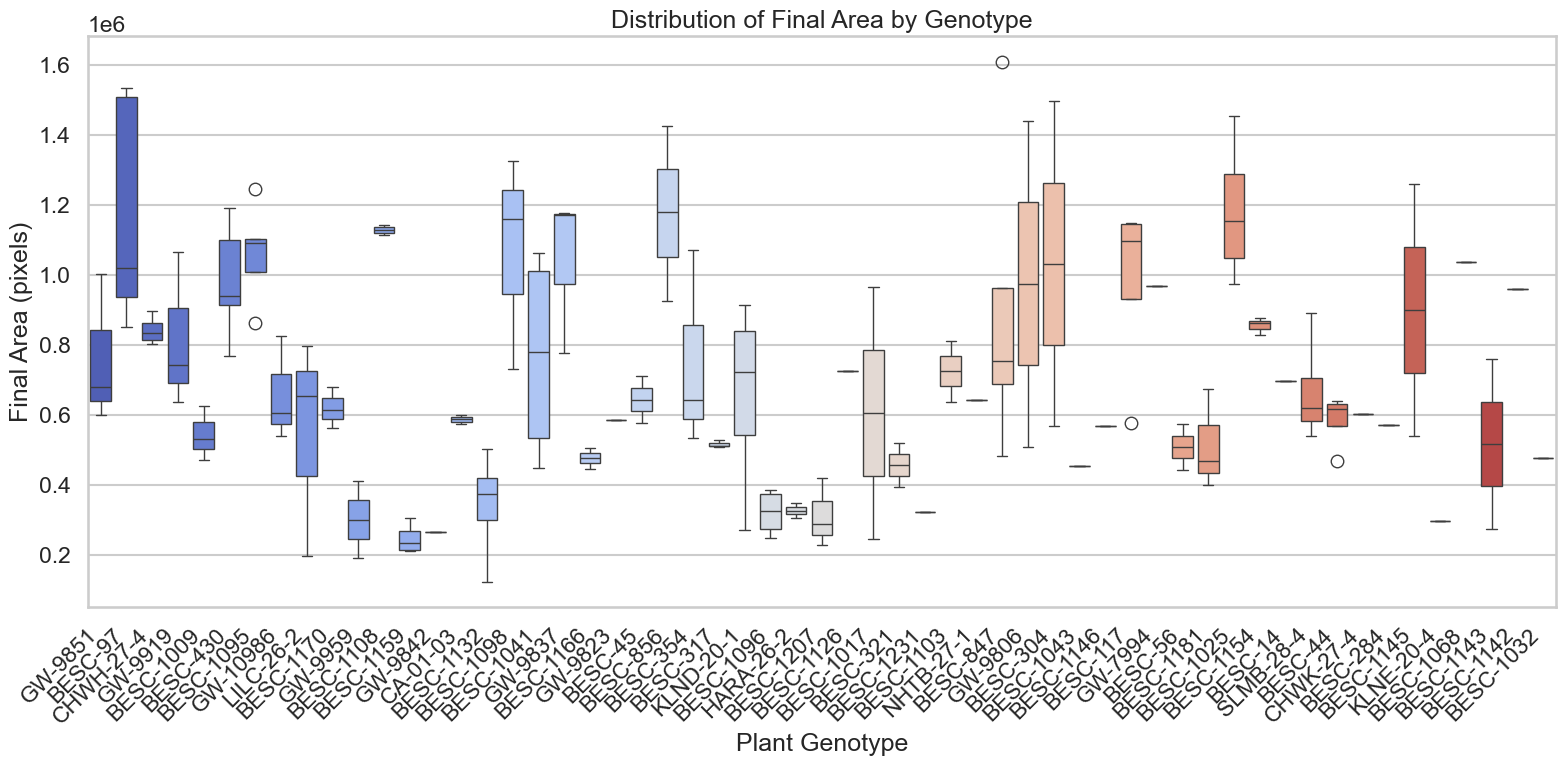


--- Heritability of Final Area ---
     Trait  MS Genotype     MS Error  n_r       Var(G)       Var(E)       Var(P)    H²
Final Area 1.917044e+11 5.779185e+10  1.9 7.040198e+10 5.779185e+10 1.281938e+11 0.549


In [12]:
# --- Analysis of a Direct Trait: Final Area ---

# Find the last day data was collected
last_day = merged_df['Date'].max()

# Filter the original dataframe to get data from only the last day
final_day_data = merged_df[merged_df['Date'] == last_day]

# Calculate the mean area for each plant on that day (in case of multiple images)
final_area_per_plant = final_day_data.groupby('Plant Info')['area'].mean().reset_index()
final_area_per_plant = final_area_per_plant.rename(columns={'area': 'Final_Area'})

# Merge this new trait into your main results dataframe
results_with_final_area = pd.merge(results_df, final_area_per_plant, on='Plant Info')

# --- Now, perform the analysis on this simple, direct trait ---

# 1. Visualize the Final Area by Genotype
print("--- Visualizing Final Area ---")
plt.figure(figsize=(16, 8))
sns.boxplot(data=results_with_final_area, x='Plant Genotype', y='Final_Area', palette='coolwarm')
plt.title('Distribution of Final Area by Genotype')
plt.ylabel('Final Area (pixels)')
plt.xlabel('Plant Genotype')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Calculate the Heritability of Final Area
print("\n--- Heritability of Final Area ---")
heritability_summary = calculate_heritability(results_with_final_area, ['Final_Area'], {'Final_Area': 'Final Area'})
print(heritability_summary.to_string(index=False))